In [1]:
# import libraries to read and plot statistical analyses of marine satellite data

In [2]:
%matplotlib inline


import pandas as pd
import xarray as xr
import numpy as np
import warnings
import cmocean as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec, ticker
from scipy.ndimage.filters import gaussian_filter
warnings.filterwarnings('ignore')
import glob
import seawater as sw
from dask.diagnostics import ProgressBar

/home/bruno/miniconda3/envs/ocean/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


### Open CMEMS dataset

In [3]:
fsource = sorted(glob.glob('/home/bruno/git/CMEMS/cdm_data/oc*'))

In [4]:
#fsource.attrs

In [5]:
source   =  [xr.open_dataset(i, chunks={}) for i in fsource]
source = xr.concat(source, dim='time')

In [6]:
#source.time

In [7]:
#source.attrs

In [8]:
# load batimetria

dado = xr.open_dataset('/home/bruno/git/CMEMS/gebco/gebco_2020_n-20.0_s-40.0_w-60.0_e-40.0.nc')

In [9]:
#source

## Mask shelf

In [10]:
mask= source.sel(lon=slice(-50.0, -40.0), lat=slice(-22.0, -28))

In [11]:
mask_bat = dado.interp({'lon':mask.lon, 'lat':mask.lat}).elevation
dado.close()
mask.close()

In [12]:
# print(mask_cdm)

### médias e plots de série temporal

In [13]:
# with ProgressBar():
#     mean_chl = mask_cdm.mean(['longitude','latitude']).compute()

In [14]:
# plt.figure(figsize=(6,2))
# np.log10(mean_chl).plot(x ="time" , color='green',linestyle='-')
# plt.title('oc-cci - clorophyll mass ')

In [15]:
# plt.figure(figsize=(6,2))
# np.log10(mean_chl.sel(time=slice('2012','2020')).plot(x ="time" , color='green',linestyle='-')
# plt.title('oc-cci - clorophyll mass ')

#### Funçoes para diagramas de  Hovmollers 

In [16]:
# função montar uma matrix para um vetor de batimetria "suave #
def extract_bat(lon,lat,topo,level,flevel):
    CT = plt.contour(gaussian_filter(lon,flevel),
                     gaussian_filter(lat,flevel),gaussian_filter(topo,flevel),
                     [level],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    # CT = plt.contour(lon,lat,topo,[-100],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    lli = []
    for i in range(len(CT.allsegs[0])):
        print(CT.allsegs[0][i].shape[0])
        lli.append(CT.allsegs[0][i].shape[0])
        
    lbat = CT.allsegs[0][np.argmax(lli)]
    print('Maior shape é'.format(CT.allsegs[0][np.argmax(lli)].shape))

    return lbat[:,0],lbat[:,1]

In [17]:
def hov_ext_cdm_dist(x,y,d_file):

    hov_cdm = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_cdm.append(d_file.sel(lon=xi[i], lat=yi[i], method='nearest'))

    hov_cdm = xr.concat(hov_cdm,dim='distance')
    hov_cdm = hov_cdm.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_cdm = hov_cdm.compute()
        
    hov_cdm = hov_cdm.interpolate_na('distance').interpolate_na('time')
    
    return hov_cdm

311
Maior shape é
311
Maior shape é


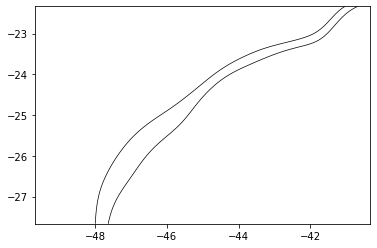

In [18]:
#----------- SELEÇÃO SEÇÕES DE ACORDO COM A BATIMETRIA SUAVE ---------------- #

xbat,ybat,zbat = mask_bat.lat.values,mask_bat.lon.values,mask_bat.values

x, y =  extract_bat(ybat, xbat, zbat, level = -80, flevel = 10) # SELECIONANDO VETORES
x_1, y_1 = extract_bat(ybat, xbat, zbat, level = -200, flevel = 10)
# x_2, y_2 = extract_bat(ybat, xbat, zbat, level = -600, flevel = 10)
# x_3, y_3 = extract_bat(ybat, xbat, zbat, level = -2000, flevel = 10)


#x,y = x[::10],y[::10]
# x_1,y_1 = x_1[::10],y_1[::10] 
# x_2,y_2 = x_2[::10],y_2[::10]
# x_3,y_3 = x_3[::10],y_3[::10]

### Extraindo o dado a partir da batimetria selecionada

In [19]:
hov_cdm  = hov_ext_cdm_dist(x,y,mask)
#hov_cdm_1  = hov_ext_cdm_dist(x_1,y_1,mask)
# hov_cdm_2 = hov_ext_cdm_dist(x_2,y_2,mask)
# hov_cdm_3 = hov_ext_cdm_dist(x_3,y_3,mask)

[########################################] | 100% Completed |  1min 13.7s


In [20]:
#len(hov_cdm.CDM)

### Como salvar essa variavel em um novo arquivo (subset CMEMS time serie ) netcdf4?

In [21]:
#pwd

In [22]:
#hov_chl.to_netcdf()

In [23]:
#print(hov_chl)

### teste correlaçao e covariancia entre os vetores.

In [24]:
xr.corr(hov_cdm.CDM, hov_cdm_1.CDM, dim="time")

NameError: name 'hov_cdm_1' is not defined

In [ ]:
#xr.corr(hov_cdm.CDM, hov_cdm_2.CDM, dim="time")

In [ ]:
#print(xr.corr(hov_cdm.CDM, hov_cdm_3.CDM, dim="time"))

In [ ]:
#xr.corr(hov_cdm_2.CDM, hov_cdm_3.CDM, dim="time")

### politofit

In [ ]:
#source.CDM.attrs

In [25]:
"""
Função Sinfit Created on Sat May 23 10:07:55 2020

@author: paulo
"""

from numpy import sin, cos, matrix, pi, arctan2, arange
from numpy.linalg import lstsq, norm
from numpy.random import random


def sinfit(t, z, w):
    '''
    if t is time and z is the independent variable, w is the frequency to be
    used in fitting [A*sin(w*t + phi) + a*t + b] to z. w=2*pi/P
    returns (A, phi, a, b)
    '''
    B = matrix(z).T #
    rows = [[sin(w*t), cos(w*t), t, 1] for t in t]
    A = matrix(rows)
    (w, residuals, rank, sing_vals) = lstsq(A, B, rcond=None)
    phi = arctan2(w[1, 0], w[0, 0])
    A = norm([w[0, 0], w[1, 0]], 2)
    a = w[2, 0]
    b = w[3, 0]
    return (A, phi, a, b)

sinfunc = lambda A, phi, a, b, t: A*np.sin(w*t + phi) + a*t + b

In [26]:
w = 2*np.pi/365

amp = []
phi = []
trend = []
b = []
fit = []

for d in hov_cdm.distance:
    z = np.log10(hov_cdm.CDM).sel(distance=d).values
    t = np.arange(len(z))
    
    notnan = ~np.isnan(z)
    P = sinfit(t[notnan], z[notnan], w)
    
    fiti = sinfunc(*P,t)
    
    amp.append(P[0])
    phi.append(P[1])
    trend.append(P[2])
    b.append(P[3])
    
    fit.append(fiti)
    
amp = np.array(amp)
phi = np.array(phi)
trend = np.array(trend)
b = np.array(b)
fit = np.array(fit)

In [27]:
# Adiciona as saídas da função para o Xarray.Dataset da respectiva matriz

hov_cdm = hov_cdm.assign({
    'amp':(xr.ones_like(hov_cdm.distance)*amp),
    'phi':(xr.ones_like(hov_cdm.distance)*phi),
    'trend':(xr.ones_like(hov_cdm.distance)*trend),
    'b':(xr.ones_like(hov_cdm.distance)*b),
    'fit':(xr.ones_like(hov_cdm.CDM)*fit),
})

Text(0.5, 1.0, 'ciclo sazonal fit')

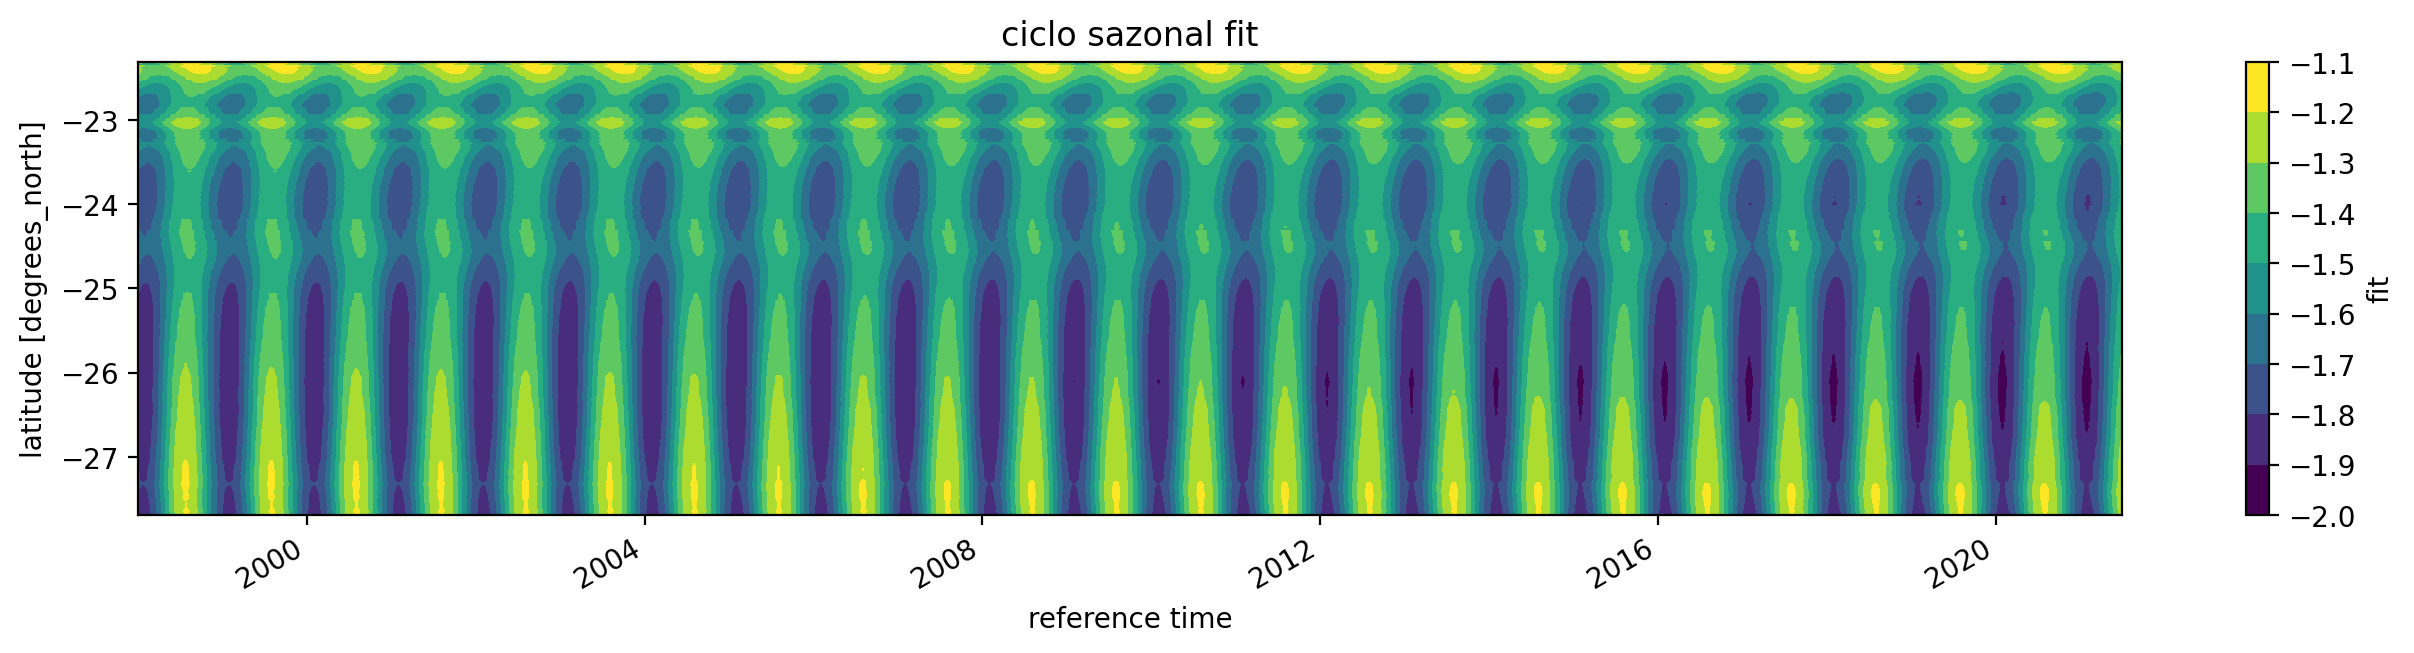

In [50]:
plt.figure(figsize=(16,3), dpi=200)
hov_cdm.fit.plot.contourf(y ='lat', levels=np.arange(-2.0, -1.0, 0.1), x='time', robust=True)
plt.title('ciclo sazonal fit')

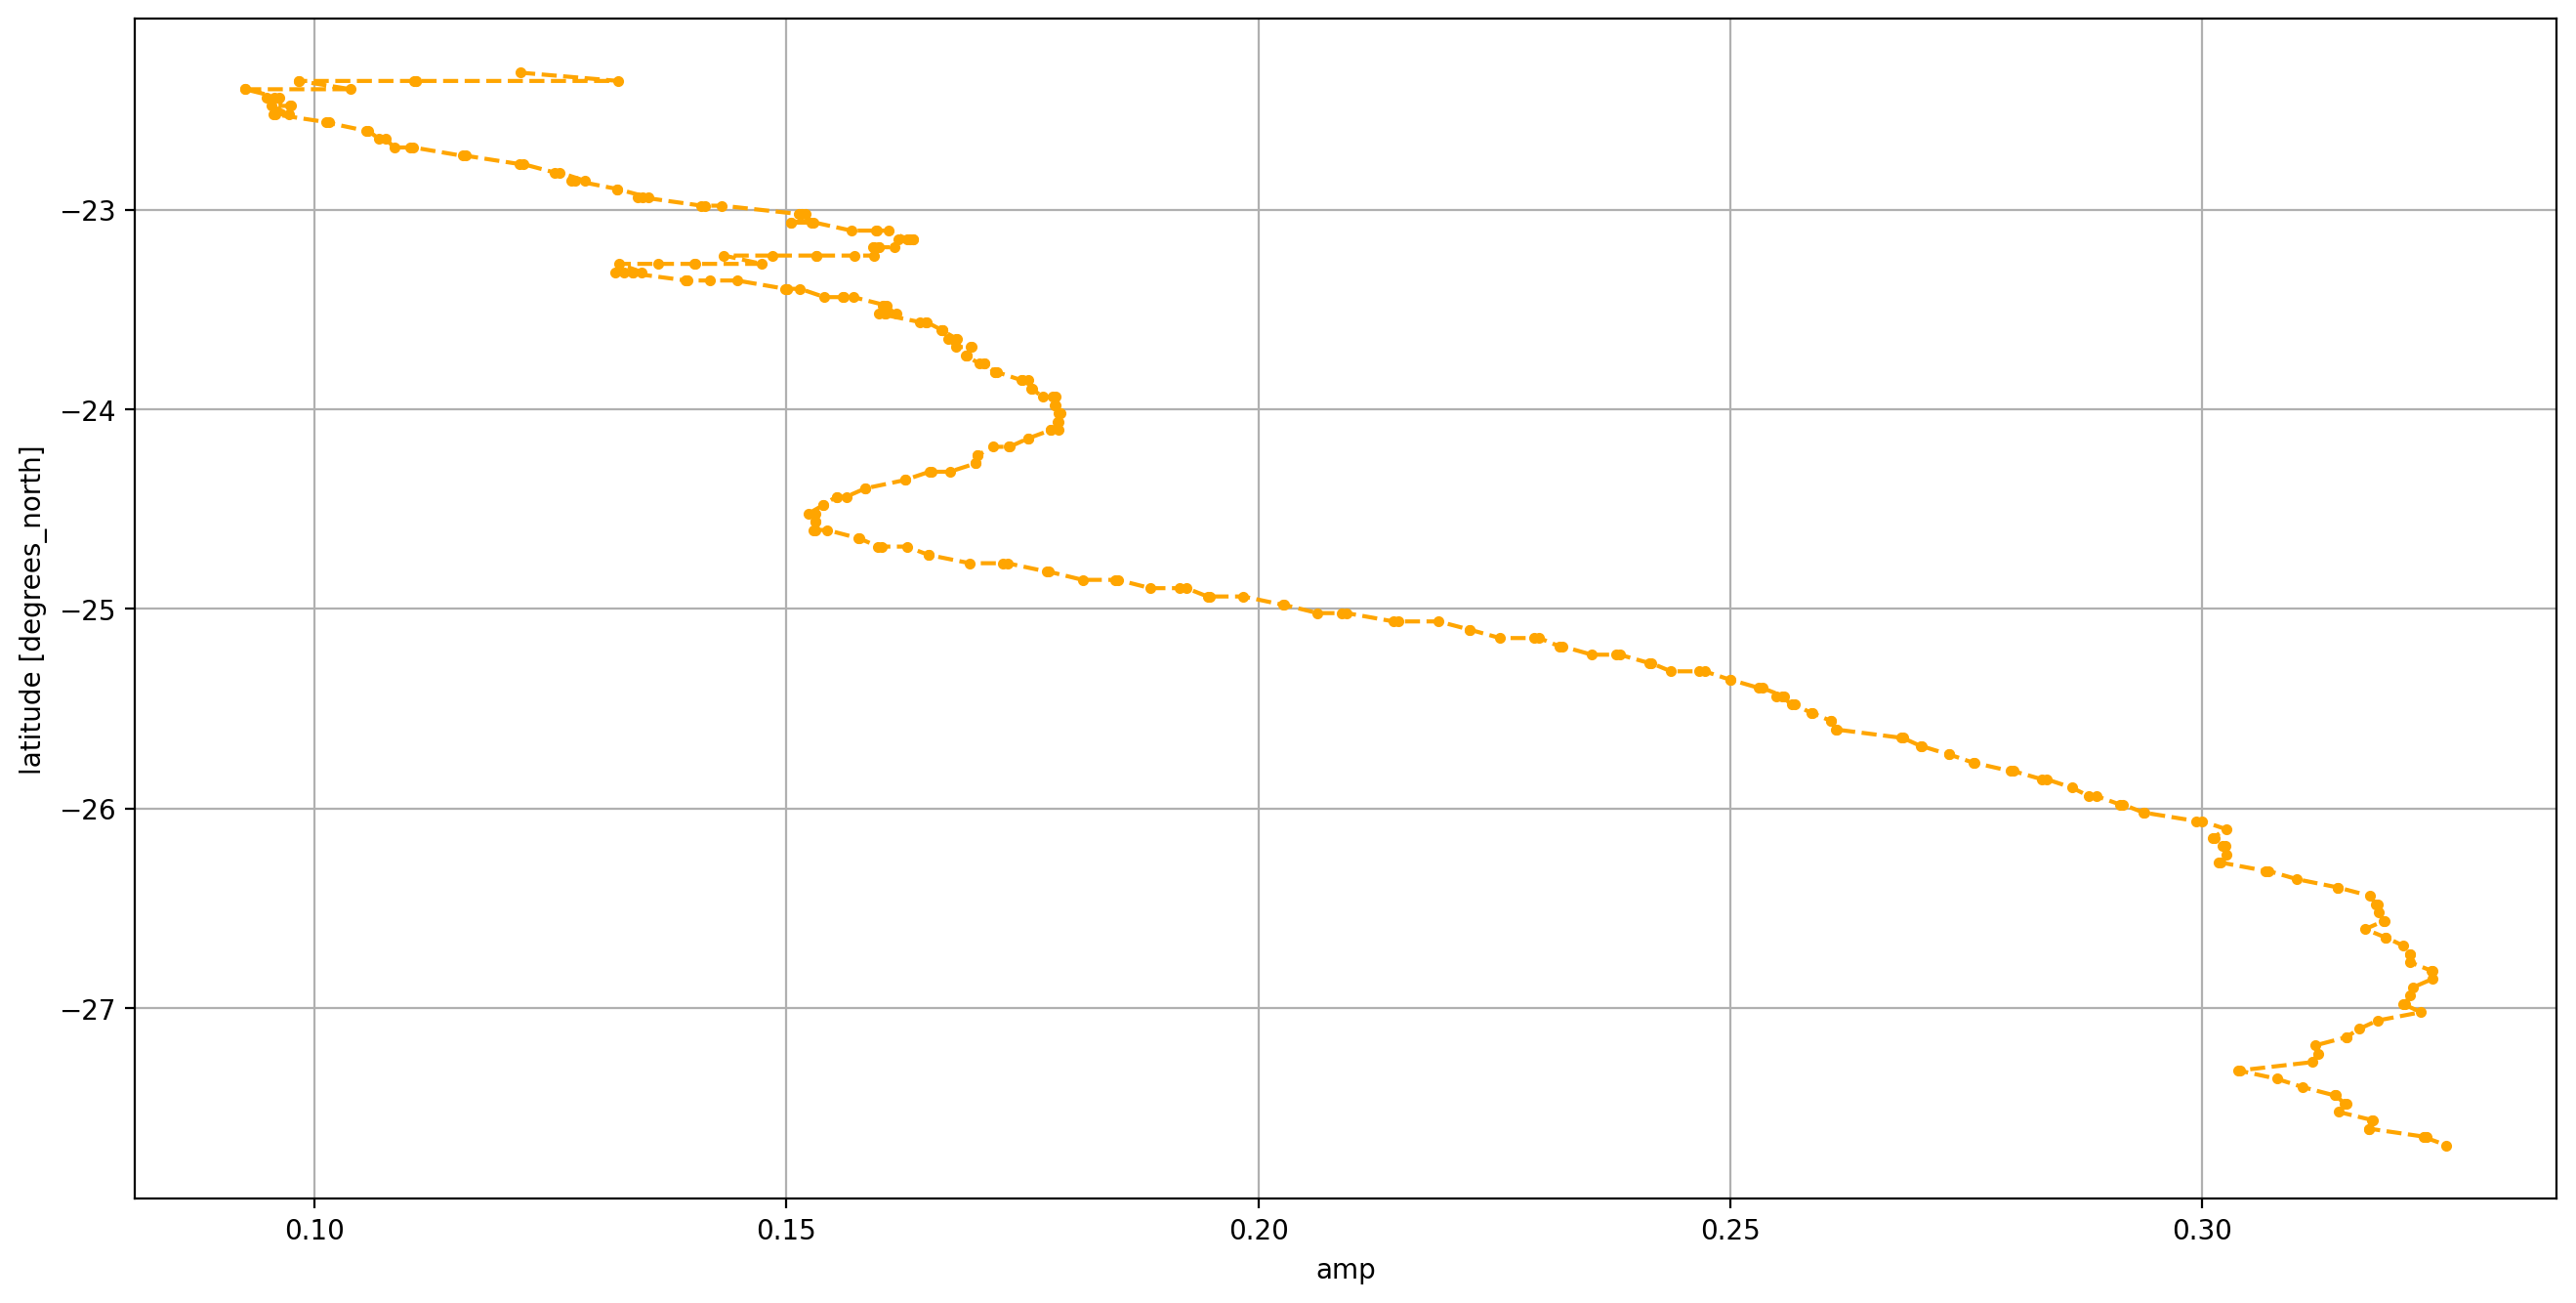

In [54]:
plt.figure(figsize=(16,8), dpi=200)
hov_cdm.amp.plot.line(y ='lat', 
                        color='orange', marker='.', linestyle='--')
plt.grid(True)

In [ ]:
plt.figure(figsize=(12,4), dpi=200)
hov_cdm.phi.plot.line(x ='lat', 
                        color='black', marker='.', linestyle='--')
plt.grid(True)

In [ ]:
plt.figure(figsize=(12,4), dpi=200)
hov_cdm.b.plot.line(x ='lat', color='black', marker='.', linestyle='-')
plt.grid(True)

In [19]:
plt.figure(figsize=(12,4), dpi=200)
hov_cdm.trend.plot.line(x ='lat', color='black', marker='.', linestyle='-')
plt.grid(True)

AttributeError: 'Dataset' object has no attribute 'trend'

<Figure size 2400x800 with 0 Axes>

##### hovmoller

Text(0.5, 1.0, '$log_{10}$[aCDM - m$^{-1}$]- shelf - 01/01/1998 to 30/06/2021')

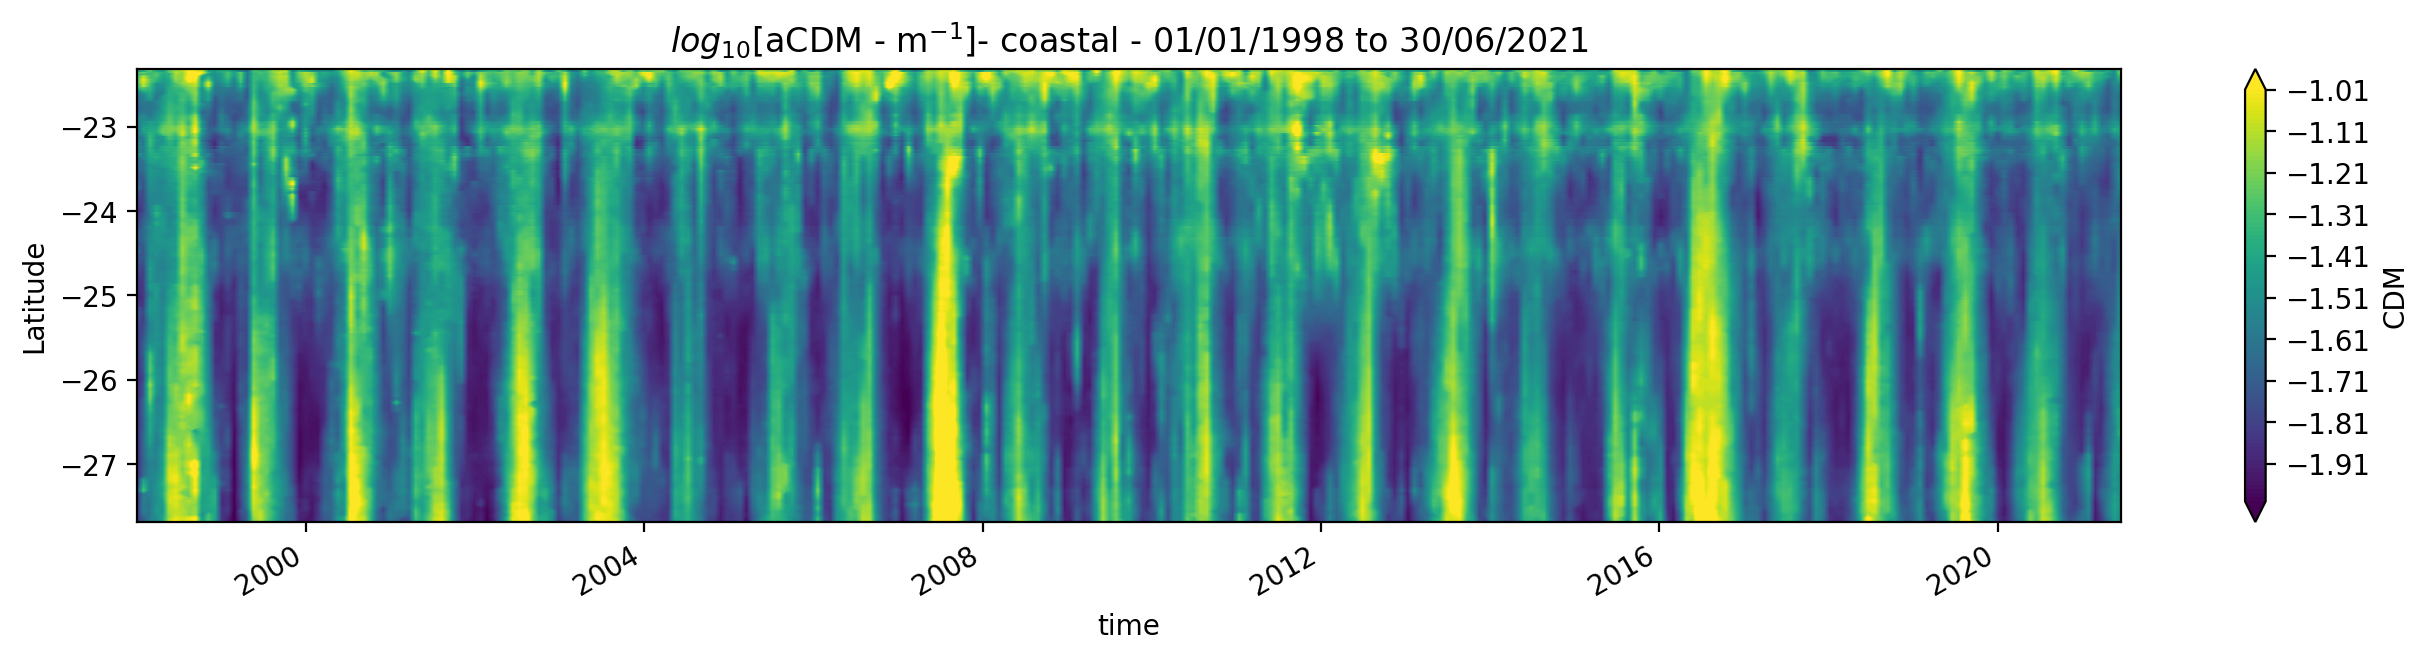

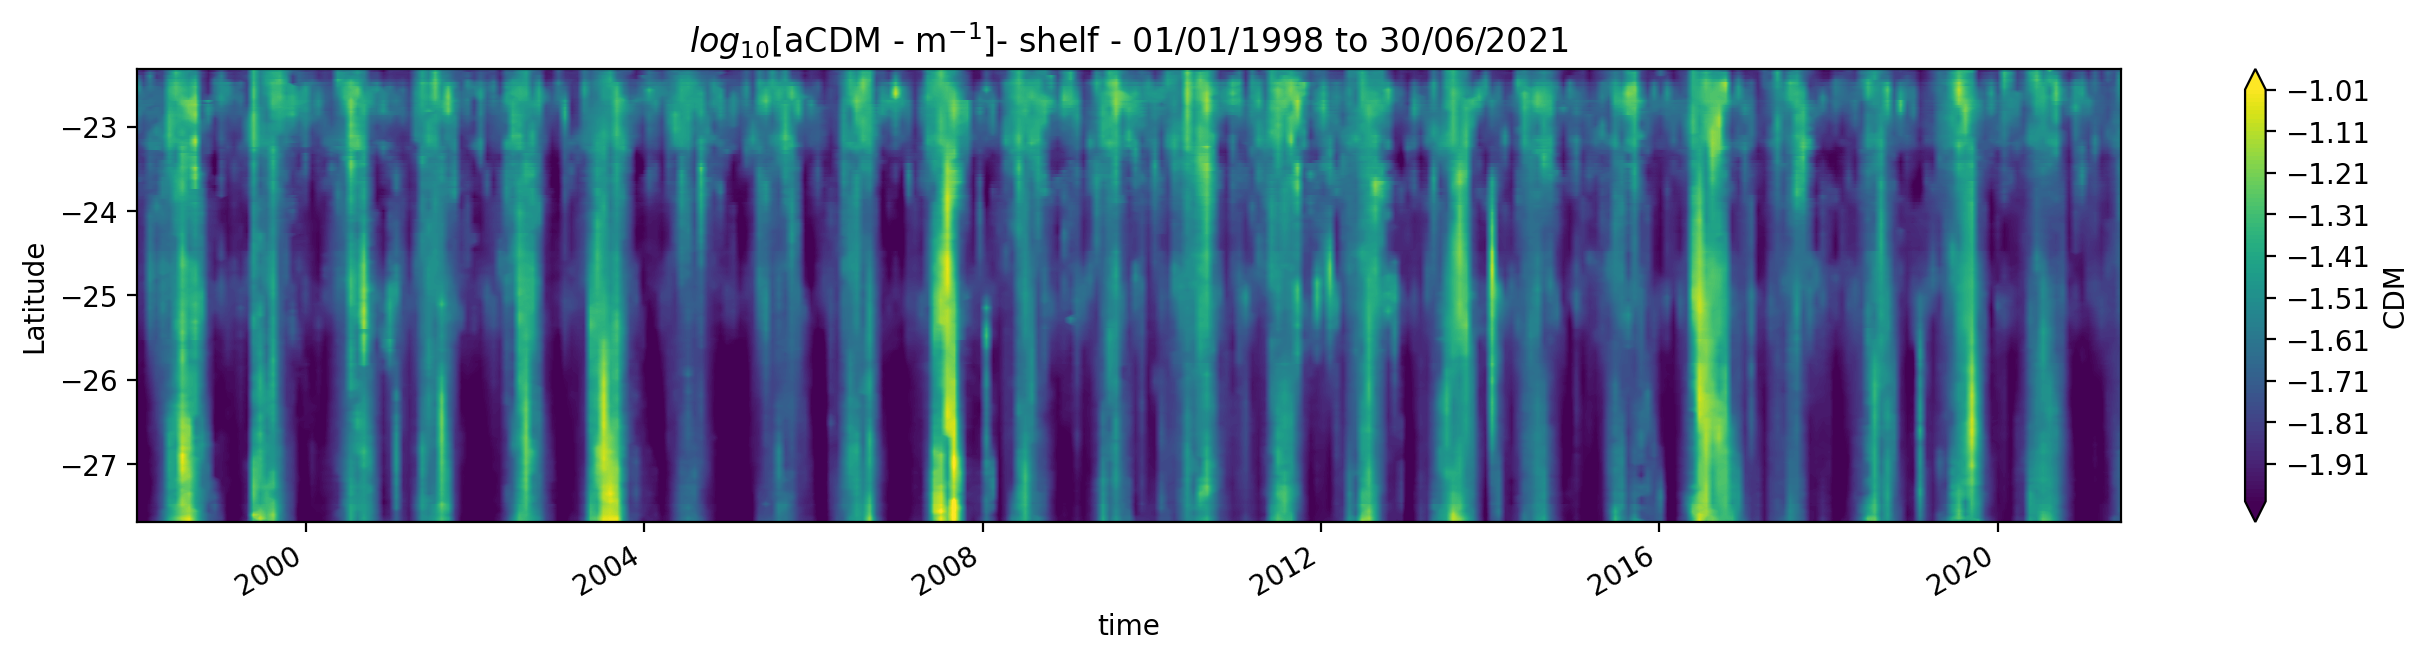

In [45]:
plt.figure(figsize=(16 ,3), dpi =200)
np.log10(hov_cdm.CDM).resample({'time':'28D'}).mean().plot.contourf(
    y='lat', vmin= -2.0, vmax=-0.9, levels=np.arange(-2.0, -1.0, 0.01),cmap= 'viridis' ,robuste=True)
#plt.xlabel('Year')
plt.ylabel('Latitude')
plt.title(r'$log_{10}$[aCDM - m$^{-1}$]''- coastal - ''01/01/1998 to 30/06/2021')
# cbar= f1.colorbar(f1, ax=[ax], orientation="vertical", aspect=15, fraction=0.009, pad=0.03)
# cbar.set_label()
#plt.tight_layout()

plt.figure(figsize=(16 ,3), dpi =200)
np.log10(hov_cdm_1.CDM).resample({'time':'28D'}).mean().plot.contourf(
    y='lat', vmin= -2.0, vmax=-0.9, levels=np.arange(-2.0, -1.0, 0.01),cmap= 'viridis' ,robuste=True)
#plt.xlabel('Year')
plt.ylabel('Latitude')
plt.title(r'$log_{10}$[aCDM - m$^{-1}$]' '- shelf - ' '01/01/1998 to 30/06/2021')
# cbar= f2.colorbar(f2, ax=[ax1], orientation="vertical", aspect=15, fraction=0.009, pad=0.03)
# cbar.set_label()
#plt.tight_layout()

In [ ]:
#spectral

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram as psd
from scipy.interpolate import RectBivariateSpline as rbs

In [52]:
cmap = plt.cm.inferno
fn = hov_cdm

In [53]:
# Aqui eu carrego todas as variáveis que estão no arquivo npz com o mesmo nome que foram salvas.
f = np.load(fn, allow_pickle=True)
for vn in f:
    globals()[vn] = f[vn]
    print('Carreguei {:}'.format(vn))
# Veja quem são as dimensões da sst, xerete nas variáveis, plote, namore com os dados

TypeError: expected str, bytes or os.PathLike object, not Dataset

In [ ]:
dtd = tm-tm[0]
# Mas meus dados mensais não são separados pelo mesmo tempo em dias: 1 mês = 28, 29, 30 ou 31
# dias?. Para rodar essa análise espectral interpolo numa grade regularmente espaçada, que começa e
# termina na mesma data dos dados originais. Primeiro eu crio um eixo dos tempos (tr):
tr = np.linspace(dtd[0], dtd[-1], dtd.shape[0])
# crio um interpolante - note que poderia ser dist, lat ou lon pois eu só interpolo numa dimensão:
# tempo. Isso fica evidente pois dist entra no interpolante e no interpolado.
irbs = rbs(dtd, dist, sst)
sstr = irbs(tr, dist)

In [ ]:
# calcula a densidade de potência espectral em (unidade da variável)².(unidade de tempo) no
# caso é log10(°C².dia) o psd retorna também w, a frequencia in 1/dia com N/2+1 pontos, onde N é o
# comprimento da série temporal.
w, power = psd(sstr, fs=1 / tr[1], nfft=len(tr), detrend='linear',
               return_onesided=True, axis=0)
# a integral do espectro tem que ser igual à variância
power = np.var(sstr)*power/np.sum(power)
# isto é só para não ficar imprimindo potências de 10 na barra de cores. Explica-se no caption da
# figura.
power = power*1e5
# A frequência w[0] é 'zero' que os engenheiros chamam de
# DC, depende só da tendência e pode ser excluída da análise.
w = w[1:]
power = power[1:, :]

In [ ]:
# =============================================================================
# Agora é só plotar
# =============================================================================

# o período é o inverso da frequência  e é mais legal de interpretar
P = w**-1
# ticks feitos "na unha"
Ticks = np.array([91., 183., 365., 730., 1460., 2920])**-1
Ticklabels = np.array(['3m', '6m', '1y', '2y', '4y', '8y'])
plt.ion()

fig, [aa, ac] = plt.subplots(1, 2, num=1, figsize=(10, 5), clear=True,
                       gridspec_kw={'width_ratios': [40, 1],
                                    'left': 0.06, 'right': 0.94,
                                    'top': 0.99, 'bottom': 0.1,
                                    'wspace': 0.02, 'hspace': 0.05})

vmin, vmax = (-3, 2)
cl = aa.pcolormesh(dist, w, np.log10(power), vmin=vmin, vmax=vmax,
                   shading='gouraud', cmap=cmap)
aa.grid(linestyle='dotted', color='gray', alpha=0.7)
aa.set_yscale('log')
aa.set_yticks(Ticks)
aa.set_yticks([], minor=True)
aa.set_yticklabels(Ticklabels)
aa.set_xticks(np.linspace(0, 8000, 9))
aa.set_ylabel(r'Period')
aa.set_xlabel(r'd (km)')

cb = plt.colorbar(cl, cax=ac, orientation='vertical', extend='both', label=r'SST Power ($10^5\times^\circ$C$^2$.d)')
out_p = 'sst_spectrum.png'
# plt.savefig(out_p, dpi=300)